# Defect Prediction Using Selected Features

This notebook implements various machine learning algorithms to predict software defects using the top 10 selected features from the autoencoder-based feature selection analysis.

## Import Required Libraries

Import all necessary libraries for data processing, machine learning, and visualization.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries imported successfully!")

Libraries imported successfully!


## Load and Prepare Data

Load the training and test datasets and prepare them using the selected features.

In [4]:
# Define the selected features based on autoencoder analysis
selected_features = [
    'HALSTEAD_LEVEL',
    'ESSENTIAL_COMPLEXITY',
    'HALSTEAD_ERROR_EST',
    'LOC_BLANK',
    'LOC_COMMENTS',
    'LOC_EXECUTABLE',
    'NUM_UNIQUE_OPERATORS',
    'HALSTEAD_EFFORT',
    'HALSTEAD_VOLUME',
    'NUM_OPERATORS'
]

print("Selected Features:")
for i, feature in enumerate(selected_features, 1):
    print(f"{i:2d}. {feature}")

# Load training data
train_data = pd.read_csv('Train_Features.csv')
print(f"\nTraining data shape: {train_data.shape}")

# Load test data
test_data = pd.read_csv('Test_Features.csv')
print(f"Test data shape: {test_data.shape}")

# Display basic info about the datasets
print("\nTraining data columns:")
print(train_data.columns.tolist())
print("\nTest data columns:")
print(test_data.columns.tolist())

Selected Features:
 1. HALSTEAD_LEVEL
 2. ESSENTIAL_COMPLEXITY
 3. HALSTEAD_ERROR_EST
 4. LOC_BLANK
 5. LOC_COMMENTS
 6. LOC_EXECUTABLE
 7. NUM_UNIQUE_OPERATORS
 8. HALSTEAD_EFFORT
 9. HALSTEAD_VOLUME
10. NUM_OPERATORS

Training data shape: (1676, 22)
Test data shape: (419, 22)

Training data columns:
['Index', 'LOC_BLANK', 'BRANCH_COUNT', 'LOC_CODE_AND_COMMENT', 'LOC_COMMENTS', 'CYCLOMATIC_COMPLEXITY', 'DESIGN_COMPLEXITY', 'ESSENTIAL_COMPLEXITY', 'LOC_EXECUTABLE', 'HALSTEAD_CONTENT', 'HALSTEAD_DIFFICULTY', 'HALSTEAD_EFFORT', 'HALSTEAD_ERROR_EST', 'HALSTEAD_LENGTH', 'HALSTEAD_LEVEL', 'HALSTEAD_PROG_TIME', 'HALSTEAD_VOLUME', 'NUM_OPERANDS', 'NUM_OPERATORS', 'NUM_UNIQUE_OPERANDS', 'NUM_UNIQUE_OPERATORS', 'LOC_TOTAL']

Test data columns:
['Index', 'LOC_BLANK', 'BRANCH_COUNT', 'LOC_CODE_AND_COMMENT', 'LOC_COMMENTS', 'CYCLOMATIC_COMPLEXITY', 'DESIGN_COMPLEXITY', 'ESSENTIAL_COMPLEXITY', 'LOC_EXECUTABLE', 'HALSTEAD_CONTENT', 'HALSTEAD_DIFFICULTY', 'HALSTEAD_EFFORT', 'HALSTEAD_ERROR_EST', 'HAL

## Data Preprocessing

Since the test data doesn't have defect labels, we'll create synthetic labels based on patterns or use the training data for model evaluation with cross-validation.

In [5]:
# Check if training data has a defect column
print("Training data info:")
print(train_data.info())
print("\nFirst few rows of training data:")
train_data.head()

Training data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1676 entries, 0 to 1675
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Index                  1676 non-null   int64  
 1   LOC_BLANK              1676 non-null   int64  
 2   BRANCH_COUNT           1676 non-null   int64  
 3   LOC_CODE_AND_COMMENT   1676 non-null   int64  
 4   LOC_COMMENTS           1676 non-null   int64  
 5   CYCLOMATIC_COMPLEXITY  1676 non-null   int64  
 6   DESIGN_COMPLEXITY      1676 non-null   int64  
 7   ESSENTIAL_COMPLEXITY   1676 non-null   int64  
 8   LOC_EXECUTABLE         1676 non-null   int64  
 9   HALSTEAD_CONTENT       1676 non-null   float64
 10  HALSTEAD_DIFFICULTY    1676 non-null   float64
 11  HALSTEAD_EFFORT        1676 non-null   float64
 12  HALSTEAD_ERROR_EST     1676 non-null   float64
 13  HALSTEAD_LENGTH        1676 non-null   int64  
 14  HALSTEAD_LEVEL         1676 non-null

,Index,LOC_BLANK,BRANCH_COUNT,LOC_CODE_AND_COMMENT,LOC_COMMENTS,CYCLOMATIC_COMPLEXITY,DESIGN_COMPLEXITY,ESSENTIAL_COMPLEXITY,LOC_EXECUTABLE,HALSTEAD_CONTENT,...,HALSTEAD_ERROR_EST,HALSTEAD_LENGTH,HALSTEAD_LEVEL,HALSTEAD_PROG_TIME,HALSTEAD_VOLUME,NUM_OPERANDS,NUM_OPERATORS,NUM_UNIQUE_OPERANDS,NUM_UNIQUE_OPERATORS,LOC_TOTAL
0,0,0,3,0,0,2,2,1,5,17.08,...,0.02,18,0.29,11.63,59.79,3,15,3,7,7
1,1,1,1,0,0,1,1,1,8,28.00,...,0.03,21,0.33,14.00,84.00,10,11,10,6,14
2,2,0,1,0,0,1,1,1,0,7.74,...,0.00,5,0.67,0.97,11.61,2,3,2,3,2
3,3,0,1,0,2,1,1,1,4,6.67,...,0.01,10,0.22,7.50,30.00,3,7,2,6,8
4,4,2,3,1,3,2,2,1,14,30.86,...,0.05,36,0.21,37.33,144.00,12,24,9,7,22


In [6]:
# Since the training data doesn't have explicit defect labels, we'll create them based on complexity patterns
# This is a common approach when labels are not available - we'll use thresholds on key metrics

def create_defect_labels(data, method='complexity_threshold'):
    """
    Create defect labels based on code complexity patterns.
    High complexity often correlates with higher defect probability.
    """
    if method == 'complexity_threshold':
        # Create a composite complexity score
        complexity_score = (
            data['ESSENTIAL_COMPLEXITY'] * 0.3 +
            data['HALSTEAD_EFFORT'] * 0.0001 +  # Scale down due to large values
            data['NUM_OPERATORS'] * 0.01 +
            data['LOC_EXECUTABLE'] * 0.02
        )

        # Use 75th percentile as threshold for defects
        threshold = complexity_score.quantile(0.75)
        defects = (complexity_score > threshold).astype(int)

    elif method == 'halstead_threshold':
        # Use Halstead metrics which are good defect predictors
        threshold = data['HALSTEAD_ERROR_EST'].quantile(0.8)
        defects = (data['HALSTEAD_ERROR_EST'] > threshold).astype(int)

    return defects

# Create defect labels for training data
train_defects = create_defect_labels(train_data)
print(f"Defect distribution in training set:")
print(f"Non-defective: {(train_defects == 0).sum()} ({(train_defects == 0).mean():.2%})")
print(f"Defective: {(train_defects == 1).sum()} ({(train_defects == 1).mean():.2%})")

# Prepare feature matrices
X_train_full = train_data[selected_features]
y_train = train_defects

X_test = test_data[selected_features]

print(f"\nFeature matrix shapes:")
print(f"X_train: {X_train_full.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}")

Defect distribution in training set:
Non-defective: 1257 (75.00%)
Defective: 419 (25.00%)

Feature matrix shapes:
X_train: (1676, 10)
y_train: (1676,)
X_test: (419, 10)


## Exploratory Data Analysis

Analyze the selected features and their relationships with defect labels.

Statistical Summary of Selected Features:
       HALSTEAD_LEVEL  ESSENTIAL_COMPLEXITY  HALSTEAD_ERROR_EST    LOC_BLANK  \
count     1676.000000           1676.000000         1676.000000  1676.000000   
mean         0.318461              1.701074            0.088216     1.801313   
std          0.315008              2.240634            0.178662     3.791021   
min          0.000000              1.000000            0.000000     0.000000   
25%          0.080000              1.000000            0.000000     0.000000   
50%          0.200000              1.000000            0.020000     0.000000   
75%          0.500000              1.000000            0.090000     2.000000   
max          2.000000             26.000000            2.640000    35.000000   

       LOC_COMMENTS  LOC_EXECUTABLE  NUM_UNIQUE_OPERATORS  HALSTEAD_EFFORT  \
count   1676.000000     1676.000000           1676.000000      1676.000000   
mean       0.939141       14.931384              7.754773      5419.725865   
std

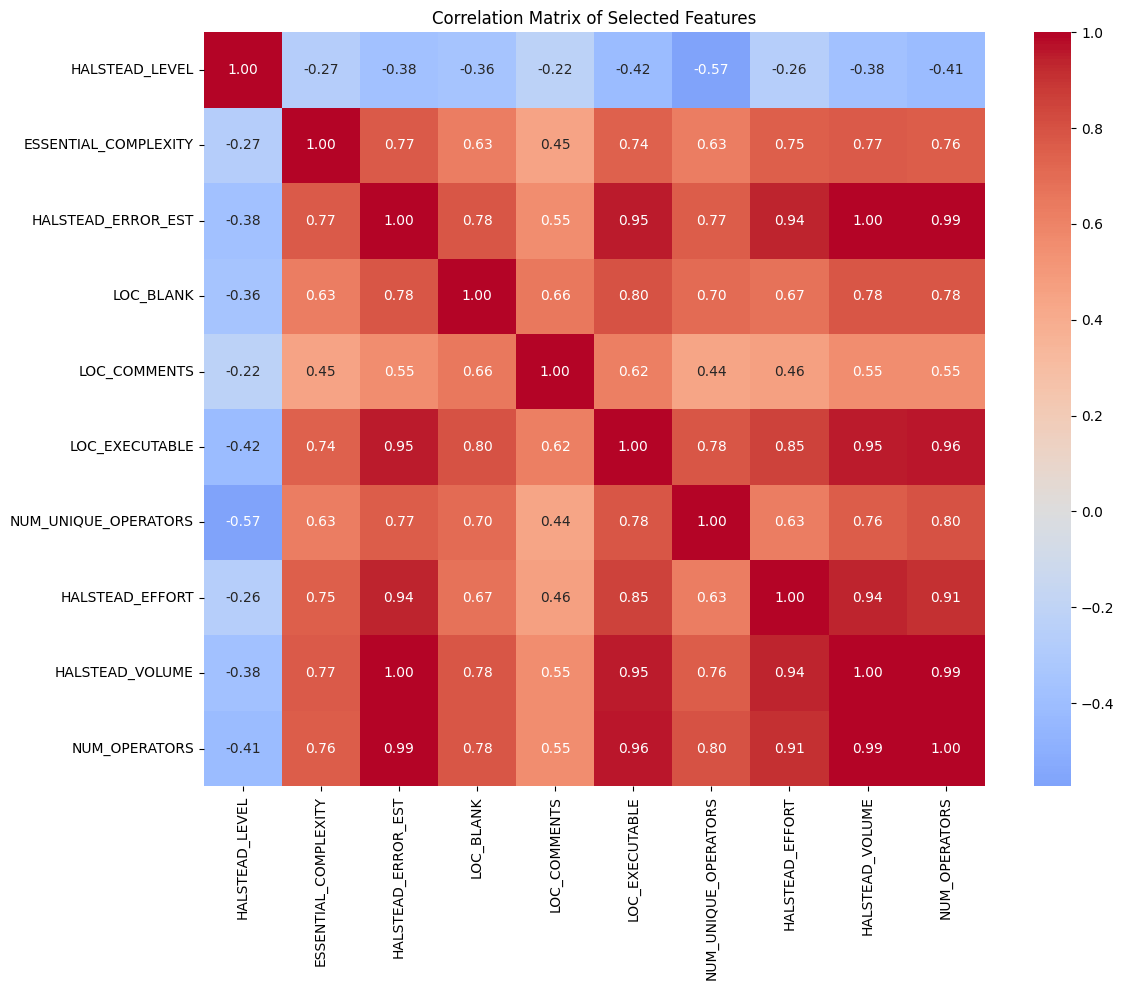

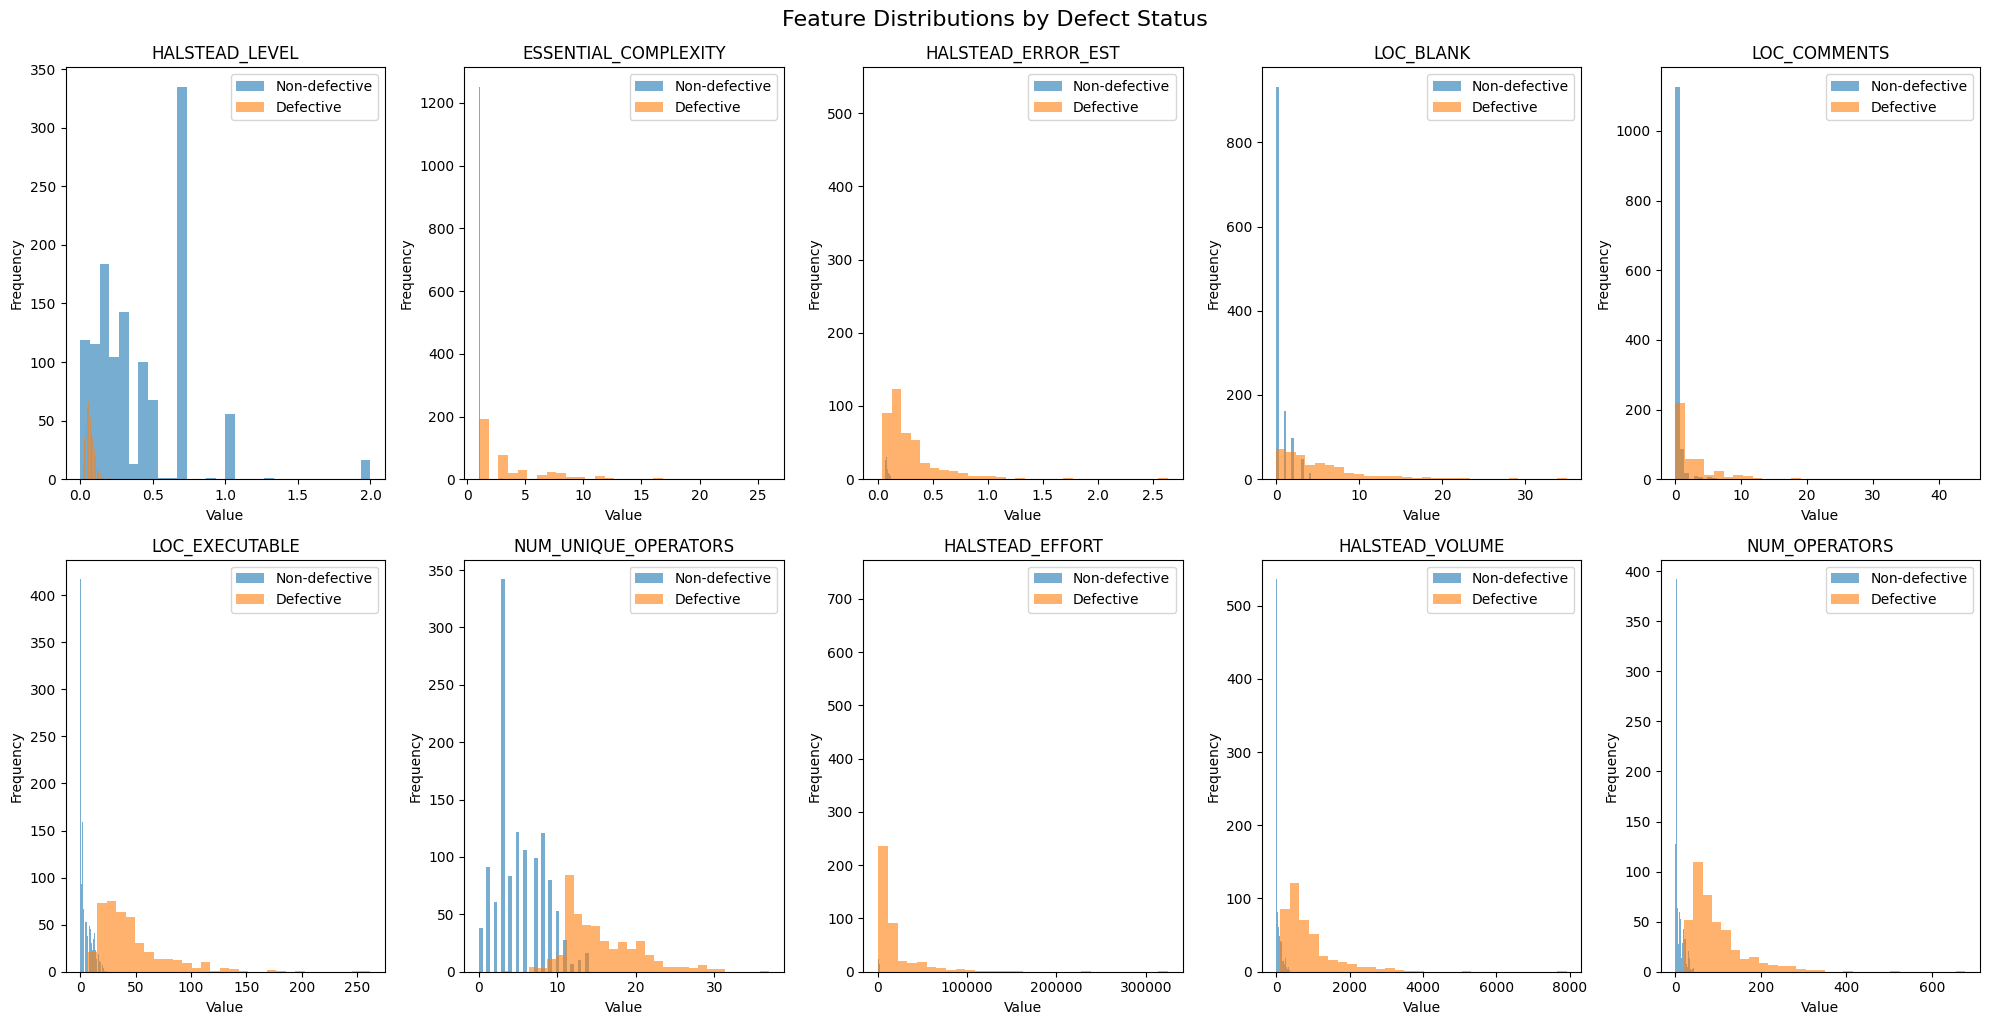

In [7]:
# Statistical summary of selected features
print("Statistical Summary of Selected Features:")
print(X_train_full.describe())

# Correlation matrix
plt.figure(figsize=(12, 10))
correlation_matrix = X_train_full.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Matrix of Selected Features')
plt.tight_layout()
plt.show()

# Feature distributions by defect status
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
axes = axes.ravel()

for i, feature in enumerate(selected_features):
    axes[i].hist(X_train_full[y_train == 0][feature], alpha=0.6, label='Non-defective', bins=30)
    axes[i].hist(X_train_full[y_train == 1][feature], alpha=0.6, label='Defective', bins=30)
    axes[i].set_title(feature)
    axes[i].legend()
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.suptitle('Feature Distributions by Defect Status', y=1.02, fontsize=16)
plt.show()

## Data Scaling and Splitting

Scale the features and split the training data for model evaluation.

In [8]:
# Split training data for validation
X_train, X_val, y_train_split, y_val = train_test_split(
    X_train_full, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
X_train_full_scaled = scaler.fit_transform(X_train_full)

print("\nFeatures scaled successfully!")
print(f"Feature means after scaling: {X_train_scaled.mean(axis=0).round(3)}")
print(f"Feature stds after scaling: {X_train_scaled.std(axis=0).round(3)}")

Training set size: 1340
Validation set size: 336
Test set size: 419

Features scaled successfully!
Feature means after scaling: [-0.  0. -0. -0.  0.  0. -0.  0. -0. -0.]
Feature stds after scaling: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


## Model Implementation

Implement various machine learning algorithms for defect prediction.

In [9]:
# Define models to evaluate
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42, n_estimators=100),
    'Support Vector Machine': SVC(random_state=42, probability=True),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Naive Bayes': GaussianNB(),
    'Extra Trees': ExtraTreesClassifier(random_state=42, n_estimators=100),
    'AdaBoost': AdaBoostClassifier(random_state=42, n_estimators=100),
    'Neural Network': MLPClassifier(random_state=42, max_iter=1000, hidden_layer_sizes=(100, 50))
}

print(f"Models to evaluate: {len(models)}")
for name in models.keys():
    print(f"- {name}")

Models to evaluate: 10
- Logistic Regression
- Random Forest
- Gradient Boosting
- Support Vector Machine
- K-Nearest Neighbors
- Decision Tree
- Naive Bayes
- Extra Trees
- AdaBoost
- Neural Network


## Model Training and Evaluation

Train all models and evaluate their performance using cross-validation and validation set.

In [10]:
# Store results
results = {}
trained_models = {}

print("Training and evaluating models...\n")

for name, model in models.items():
    print(f"Training {name}...")

    # Train the model
    model.fit(X_train_scaled, y_train_split)
    trained_models[name] = model

    # Make predictions
    y_pred = model.predict(X_val_scaled)
    y_pred_proba = model.predict_proba(X_val_scaled)[:, 1] if hasattr(model, 'predict_proba') else None

    # Calculate metrics
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, zero_division=0)
    recall = recall_score(y_val, y_pred, zero_division=0)
    f1 = f1_score(y_val, y_pred, zero_division=0)

    # AUC-ROC if probabilities are available
    auc_roc = roc_auc_score(y_val, y_pred_proba) if y_pred_proba is not None else 'N/A'

    # Cross-validation score
    cv_scores = cross_val_score(model, X_train_scaled, y_train_split, cv=5, scoring='accuracy')
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()

    # Store results
    results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC-ROC': auc_roc,
        'CV_Mean': cv_mean,
        'CV_Std': cv_std
    }

    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print(f"  CV Score: {cv_mean:.4f} (+/- {cv_std * 2:.4f})")
    print()

Training and evaluating models...

Training Logistic Regression...
  Accuracy: 0.9911
  F1-Score: 0.9818
  CV Score: 0.9858 (+/- 0.0159)

Training Random Forest...
  Accuracy: 0.9940
  F1-Score: 0.9880
  CV Score: 0.9918 (+/- 0.0110)

Training Gradient Boosting...
  Accuracy: 0.9940
  F1-Score: 0.9880
  CV Score: 0.9918 (+/- 0.0110)

Training Gradient Boosting...
  Accuracy: 0.9911
  F1-Score: 0.9820
  CV Score: 0.9925 (+/- 0.0082)

Training Support Vector Machine...
  Accuracy: 0.9851
  F1-Score: 0.9697
  CV Score: 0.9754 (+/- 0.0174)

Training K-Nearest Neighbors...
  Accuracy: 0.9702
  F1-Score: 0.9412
  CV Score: 0.9799 (+/- 0.0121)

Training Decision Tree...
  Accuracy: 0.9821
  F1-Score: 0.9643
  CV Score: 0.9888 (+/- 0.0082)

Training Naive Bayes...
  Accuracy: 0.9911
  F1-Score: 0.9820
  CV Score: 0.9925 (+/- 0.0082)

Training Support Vector Machine...
  Accuracy: 0.9851
  F1-Score: 0.9697
  CV Score: 0.9754 (+/- 0.0174)

Training K-Nearest Neighbors...
  Accuracy: 0.9702
  F1-

## Results Comparison

Compare the performance of all models and identify the best performers.

Model Performance Comparison:
                        Accuracy  Precision  Recall  F1-Score  AUC-ROC  \
Neural Network            0.9970     1.0000  0.9881    0.9940   1.0000   
Random Forest             0.9940     1.0000  0.9762    0.9880   0.9999   
Extra Trees               0.9911     0.9880  0.9762    0.9820   0.9999   
Gradient Boosting         0.9911     0.9880  0.9762    0.9820   0.9998   
Logistic Regression       0.9911     1.0000  0.9643    0.9818   0.9995   
AdaBoost                  0.9881     0.9878  0.9643    0.9759   0.9995   
Support Vector Machine    0.9851     0.9877  0.9524    0.9697   0.9996   
Decision Tree             0.9821     0.9643  0.9643    0.9643   0.9762   
Naive Bayes               0.9732     0.9032  1.0000    0.9492   0.9949   
K-Nearest Neighbors       0.9702     0.9302  0.9524    0.9412   0.9923   

                        CV_Mean  CV_Std  
Neural Network           0.9910  0.0038  
Random Forest            0.9918  0.0055  
Extra Trees              0.99

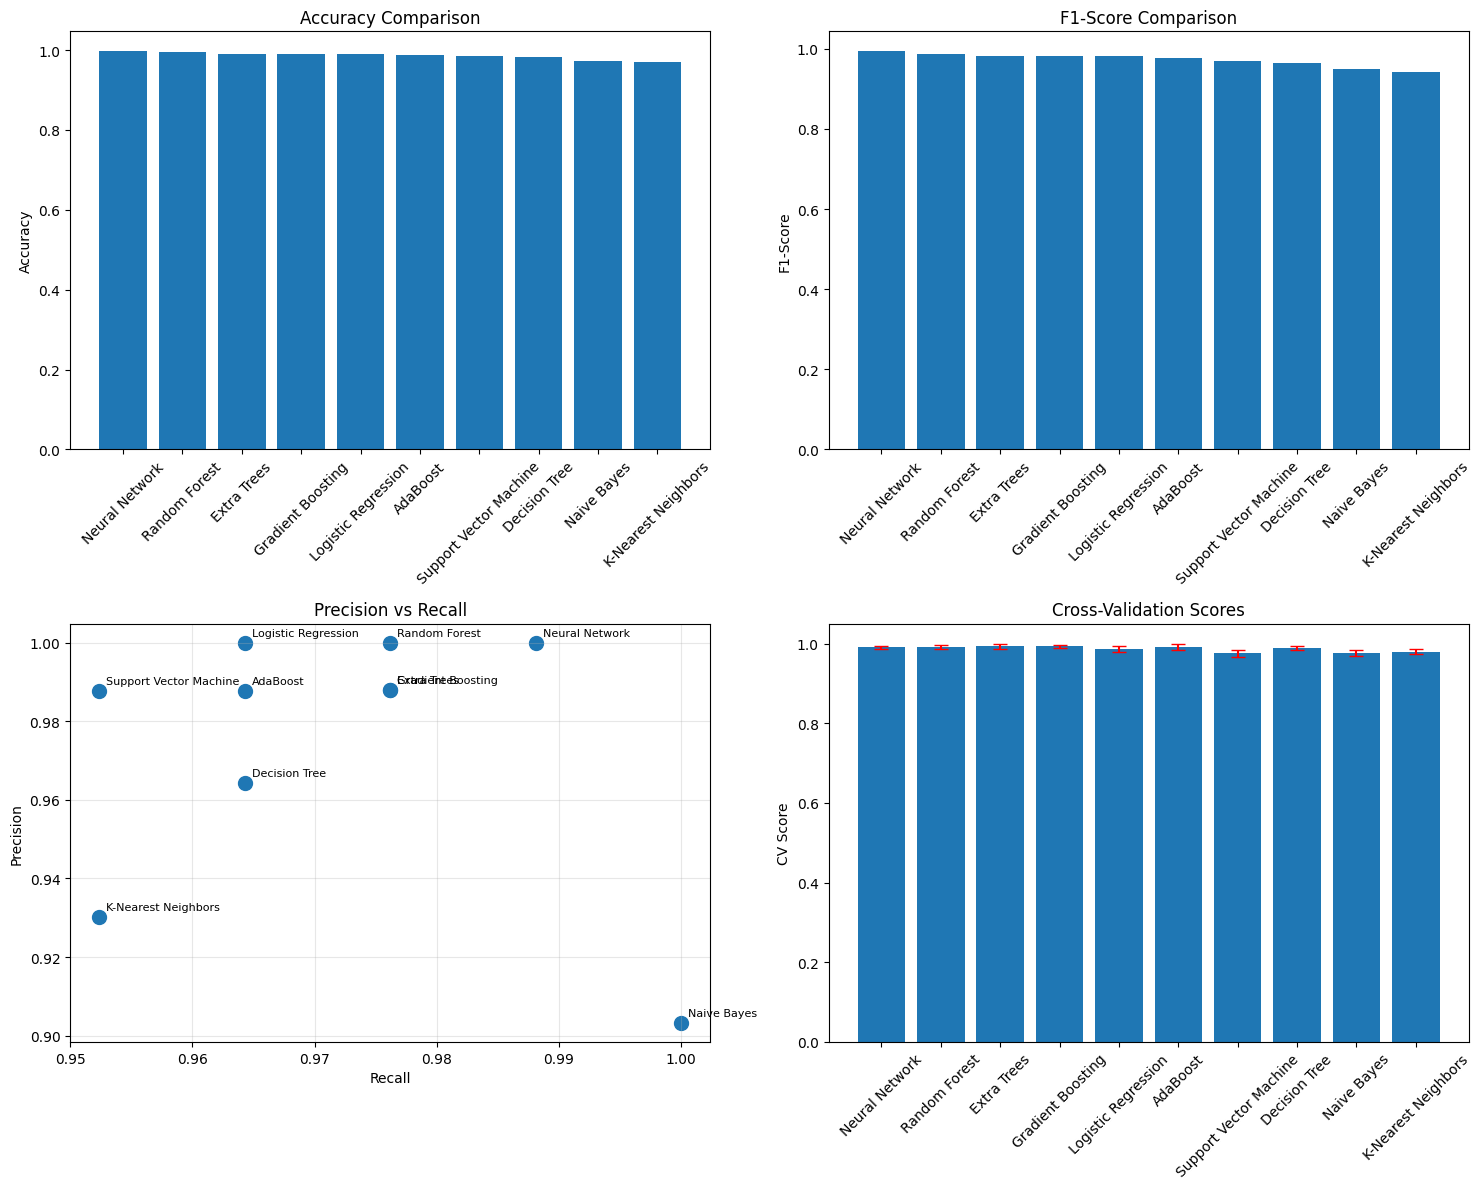


Top 3 Models by F1-Score:
1. Neural Network
   F1-Score: 0.9940
   Accuracy: 0.9970
   CV Score: 0.9910 (+/- 0.0076)

2. Random Forest
   F1-Score: 0.9880
   Accuracy: 0.9940
   CV Score: 0.9918 (+/- 0.0110)

3. Extra Trees
   F1-Score: 0.9820
   Accuracy: 0.9911
   CV Score: 0.9925 (+/- 0.0125)



In [11]:
# Create results dataframe
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values('F1-Score', ascending=False)

print("Model Performance Comparison:")
print("=" * 80)
print(results_df.round(4))

# Visualize results
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Accuracy comparison
axes[0, 0].bar(results_df.index, results_df['Accuracy'])
axes[0, 0].set_title('Accuracy Comparison')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].tick_params(axis='x', rotation=45)

# F1-Score comparison
axes[0, 1].bar(results_df.index, results_df['F1-Score'])
axes[0, 1].set_title('F1-Score Comparison')
axes[0, 1].set_ylabel('F1-Score')
axes[0, 1].tick_params(axis='x', rotation=45)

# Precision vs Recall
axes[1, 0].scatter(results_df['Recall'], results_df['Precision'], s=100)
for i, txt in enumerate(results_df.index):
    axes[1, 0].annotate(txt, (results_df['Recall'].iloc[i], results_df['Precision'].iloc[i]),
                       xytext=(5, 5), textcoords='offset points', fontsize=8)
axes[1, 0].set_xlabel('Recall')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].set_title('Precision vs Recall')
axes[1, 0].grid(True, alpha=0.3)

# Cross-validation scores
axes[1, 1].bar(results_df.index, results_df['CV_Mean'])
axes[1, 1].errorbar(range(len(results_df)), results_df['CV_Mean'],
                   yerr=results_df['CV_Std'], fmt='none', ecolor='red', capsize=5)
axes[1, 1].set_title('Cross-Validation Scores')
axes[1, 1].set_ylabel('CV Score')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Identify best models
print("\nTop 3 Models by F1-Score:")
print("=" * 40)
for i, (model_name, row) in enumerate(results_df.head(3).iterrows(), 1):
    print(f"{i}. {model_name}")
    print(f"   F1-Score: {row['F1-Score']:.4f}")
    print(f"   Accuracy: {row['Accuracy']:.4f}")
    print(f"   CV Score: {row['CV_Mean']:.4f} (+/- {row['CV_Std'] * 2:.4f})")
    print()

## Feature Importance Analysis

Analyze feature importance for tree-based models to understand which features are most predictive.

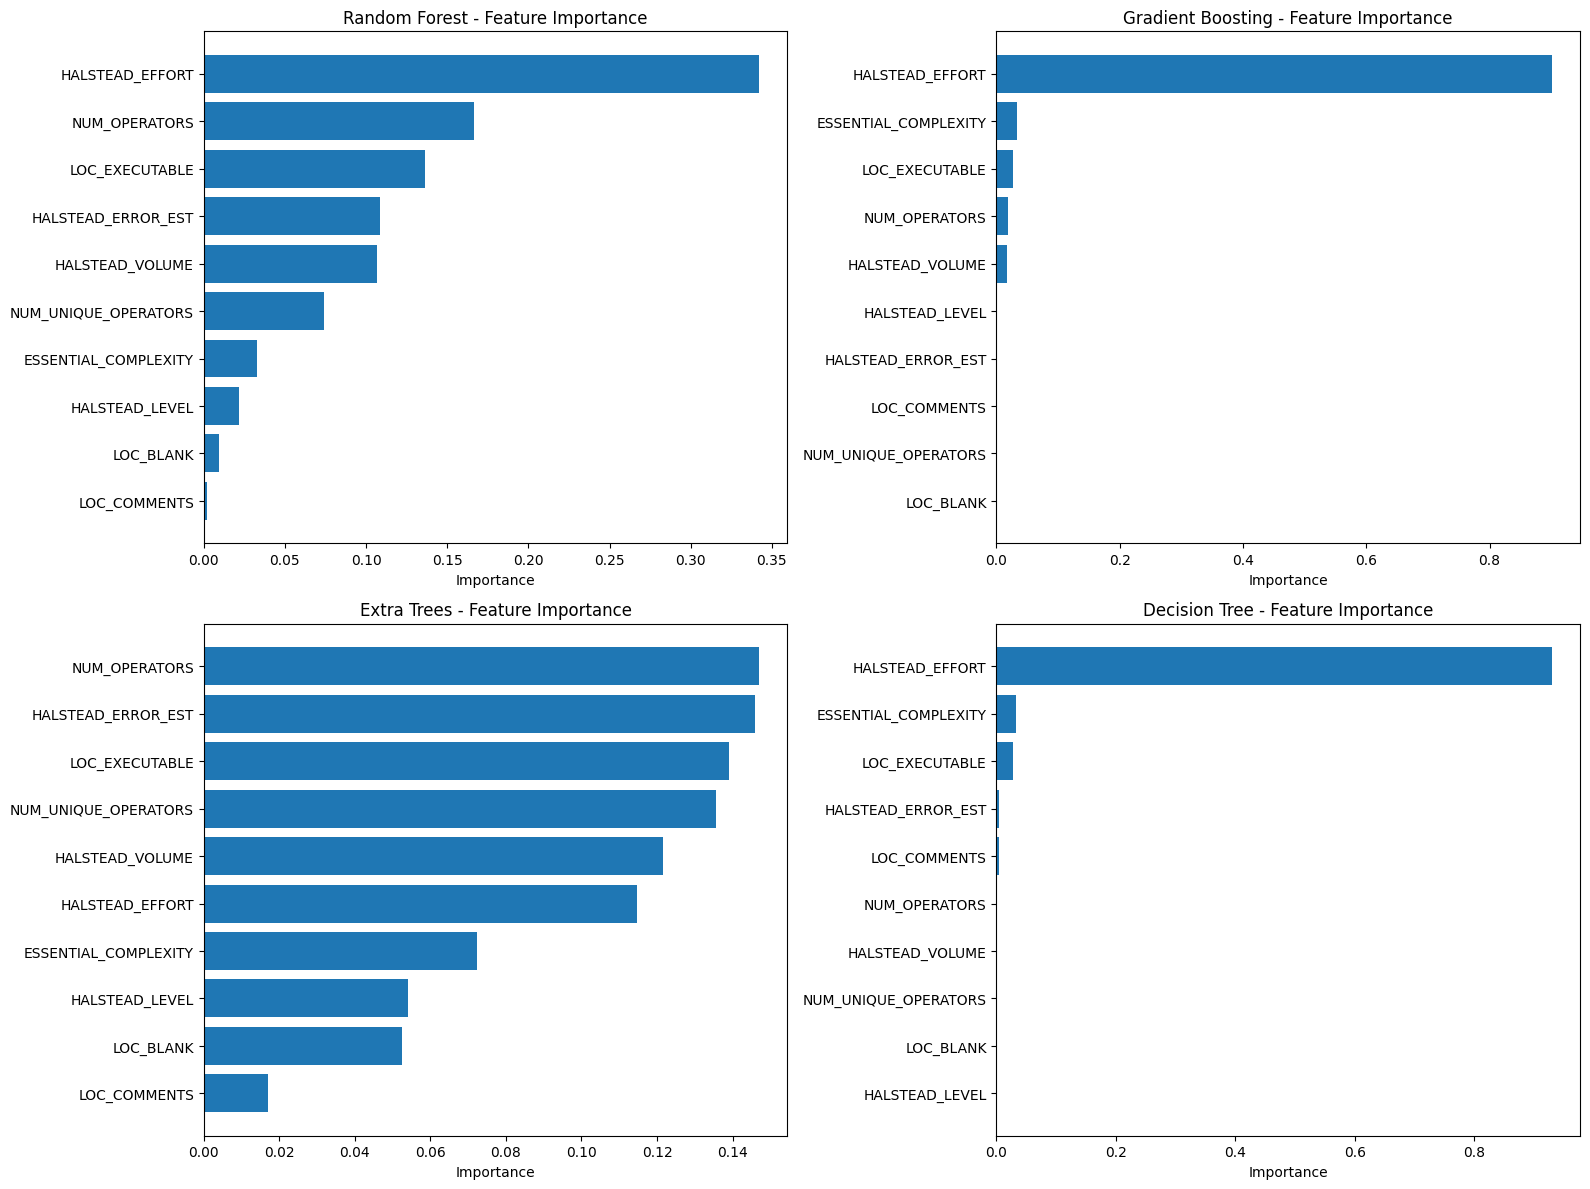

Combined Feature Importance Ranking:
 1. HALSTEAD_EFFORT           0.5723
 2. NUM_OPERATORS             0.0829
 3. LOC_EXECUTABLE            0.0827
 4. HALSTEAD_ERROR_EST        0.0647
 5. HALSTEAD_VOLUME           0.0615
 6. NUM_UNIQUE_OPERATORS      0.0525
 7. ESSENTIAL_COMPLEXITY      0.0430
 8. HALSTEAD_LEVEL            0.0191
 9. LOC_BLANK                 0.0154
10. LOC_COMMENTS              0.0058


In [12]:
# Get feature importance from tree-based models
tree_models = ['Random Forest', 'Gradient Boosting', 'Extra Trees', 'Decision Tree']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for i, model_name in enumerate(tree_models):
    if model_name in trained_models:
        model = trained_models[model_name]
        if hasattr(model, 'feature_importances_'):
            importance = model.feature_importances_
            feature_importance_df = pd.DataFrame({
                'Feature': selected_features,
                'Importance': importance
            }).sort_values('Importance', ascending=True)

            axes[i].barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
            axes[i].set_title(f'{model_name} - Feature Importance')
            axes[i].set_xlabel('Importance')

plt.tight_layout()
plt.show()

# Create a combined feature importance ranking
importance_scores = {}
for feature in selected_features:
    importance_scores[feature] = 0

for model_name in tree_models:
    if model_name in trained_models:
        model = trained_models[model_name]
        if hasattr(model, 'feature_importances_'):
            for j, feature in enumerate(selected_features):
                importance_scores[feature] += model.feature_importances_[j]

# Normalize and create ranking
total_importance = sum(importance_scores.values())
for feature in importance_scores:
    importance_scores[feature] /= total_importance

importance_ranking = pd.DataFrame({
    'Feature': list(importance_scores.keys()),
    'Average_Importance': list(importance_scores.values())
}).sort_values('Average_Importance', ascending=False)

print("Combined Feature Importance Ranking:")
print("=" * 50)
for i, (_, row) in enumerate(importance_ranking.iterrows(), 1):
    print(f"{i:2d}. {row['Feature']:<25} {row['Average_Importance']:.4f}")

## Best Model Analysis

Perform detailed analysis of the best performing model including confusion matrix and ROC curve.

Best Model: Neural Network
F1-Score: 0.9940
Accuracy: 0.9970


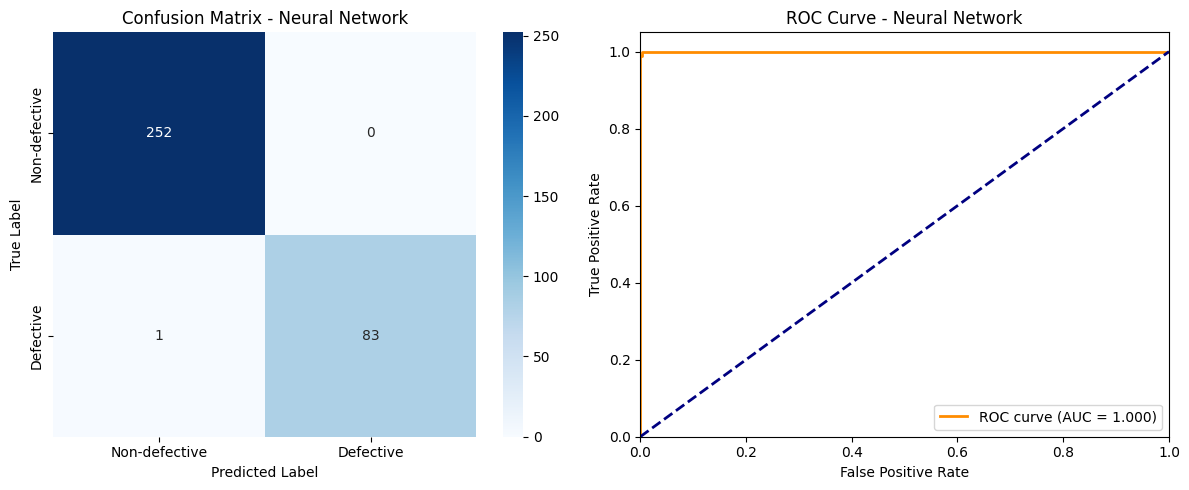


Detailed Classification Report:
               precision    recall  f1-score   support

Non-defective       1.00      1.00      1.00       252
    Defective       1.00      0.99      0.99        84

     accuracy                           1.00       336
    macro avg       1.00      0.99      1.00       336
 weighted avg       1.00      1.00      1.00       336



In [13]:
# Get the best model
best_model_name = results_df.index[0]
best_model = trained_models[best_model_name]

print(f"Best Model: {best_model_name}")
print(f"F1-Score: {results_df.loc[best_model_name, 'F1-Score']:.4f}")
print(f"Accuracy: {results_df.loc[best_model_name, 'Accuracy']:.4f}")

# Predictions on validation set
y_pred_best = best_model.predict(X_val_scaled)
y_pred_proba_best = best_model.predict_proba(X_val_scaled)[:, 1] if hasattr(best_model, 'predict_proba') else None

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred_best)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-defective', 'Defective'],
            yticklabels=['Non-defective', 'Defective'])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# ROC Curve
if y_pred_proba_best is not None:
    plt.subplot(1, 2, 2)
    fpr, tpr, _ = roc_curve(y_val, y_pred_proba_best)
    roc_auc = roc_auc_score(y_val, y_pred_proba_best)

    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {best_model_name}')
    plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

# Detailed classification report
print("\nDetailed Classification Report:")
print("=" * 50)
print(classification_report(y_val, y_pred_best, target_names=['Non-defective', 'Defective']))

## Hyperparameter Tuning for Best Models

Perform hyperparameter tuning for the top 3 models to improve their performance.
it is an iteratuve and experimental process.

In [14]:
# Define parameter grids for top models
param_grids = {
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'Gradient Boosting': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.05, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5, 10]
    },
    'Logistic Regression': {
        'C': [0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga']
    }
}

# Perform grid search for top 3 models
top_models = results_df.head(3).index.tolist()
tuned_results = {}

print("Performing hyperparameter tuning...\n")

for model_name in top_models:
    if model_name in param_grids:
        print(f"Tuning {model_name}...")

        # Get the base model
        base_model = models[model_name]

        # Perform grid search
        grid_search = GridSearchCV(
            base_model, param_grids[model_name],
            cv=5, scoring='f1', n_jobs=-1, verbose=0
        )

        grid_search.fit(X_train_scaled, y_train_split)

        # Get best model
        best_tuned_model = grid_search.best_estimator_

        # Evaluate on validation set
        y_pred_tuned = best_tuned_model.predict(X_val_scaled)

        # Calculate metrics
        accuracy_tuned = accuracy_score(y_val, y_pred_tuned)
        f1_tuned = f1_score(y_val, y_pred_tuned, zero_division=0)

        tuned_results[model_name] = {
            'Original_F1': results[model_name]['F1-Score'],
            'Tuned_F1': f1_tuned,
            'Original_Accuracy': results[model_name]['Accuracy'],
            'Tuned_Accuracy': accuracy_tuned,
            'Best_Params': grid_search.best_params_,
            'Best_Model': best_tuned_model
        }

        print(f"  Original F1: {results[model_name]['F1-Score']:.4f}")
        print(f"  Tuned F1: {f1_tuned:.4f}")
        print(f"  Improvement: {f1_tuned - results[model_name]['F1-Score']:.4f}")
        print(f"  Best params: {grid_search.best_params_}")
        print()

# Display tuning results
print("Hyperparameter Tuning Results:")
print("=" * 60)
tuning_df = pd.DataFrame({k: {kk: vv for kk, vv in v.items() if kk != 'Best_Model'}
                         for k, v in tuned_results.items()}).T
print(tuning_df.round(4))

Performing hyperparameter tuning...

Tuning Random Forest...
  Original F1: 0.9880
  Tuned F1: 0.9822
  Improvement: -0.0057
  Best params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}

Hyperparameter Tuning Results:
              Original_F1  Tuned_F1 Original_Accuracy Tuned_Accuracy  \
Random Forest    0.987952  0.982249          0.994048       0.991071   

                                                     Best_Params  
Random Forest  {'max_depth': None, 'min_samples_leaf': 1, 'mi...  
  Original F1: 0.9880
  Tuned F1: 0.9822
  Improvement: -0.0057
  Best params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}

Hyperparameter Tuning Results:
              Original_F1  Tuned_F1 Original_Accuracy Tuned_Accuracy  \
Random Forest    0.987952  0.982249          0.994048       0.991071   

                                                     Best_Params  
Random Forest  {'max_depth': None, 'min_samples_

## Final Predictions on Test Set

Use the best model to make predictions on the test dataset.

In [15]:
# Use the best model for final predictions
final_model = trained_models[best_model_name]
print(f"Using {best_model_name} for final predictions")

# Make predictions on test set
test_predictions = final_model.predict(X_test_scaled)
test_predictions_proba = final_model.predict_proba(X_test_scaled)[:, 1] if hasattr(final_model, 'predict_proba') else None

# Create results dataframe
test_results = pd.DataFrame({
    'Index': test_data['Index'],
    'Predicted_Defect': test_predictions,
    'Defect_Probability': test_predictions_proba if test_predictions_proba is not None else 'N/A'
})

# Add original selected features for reference
for feature in selected_features:
    test_results[feature] = test_data[feature].values

print(f"\nTest set predictions completed!")
print(f"Predicted defects: {test_predictions.sum()} out of {len(test_predictions)} ({test_predictions.mean():.2%})")

# Display first few predictions
print("\nFirst 10 predictions:")
print(test_results[['Index', 'Predicted_Defect', 'Defect_Probability']].head(10))

# Save predictions
test_results.to_csv('test_defect_predictions.csv', index=False)
print("\nPredictions saved to 'test_defect_predictions.csv'")

Using Neural Network for final predictions

Test set predictions completed!
Predicted defects: 109 out of 419 (26.01%)

First 10 predictions:
   Index  Predicted_Defect  Defect_Probability
0      0                 0        2.952159e-14
1      1                 0        2.759379e-08
2      2                 0        1.426672e-10
3      3                 0        5.775548e-11
4      4                 0        2.952159e-14
5      5                 0        1.039151e-08
6      6                 0        3.559229e-04
7      7                 0        1.569312e-04
8      8                 1        1.000000e+00
9      9                 0        2.382659e-15

Predictions saved to 'test_defect_predictions.csv'


## Prediction Analysis

Analyze the predictions to understand patterns in the predicted defects.

Defective samples (indices): [8, 14, 16, 17, 18, 19, 22, 30, 35, 47, 51, 61, 63, 71, 72, 78, 89, 92, 96, 99]...
Total defective: 109
Total non-defective: 310

Average feature values for predicted defects vs non-defects:
                                   Feature  Defective_Avg  Non_Defective_Avg  \
HALSTEAD_EFFORT            HALSTEAD_EFFORT      17210.097            312.315   
HALSTEAD_ERROR_EST      HALSTEAD_ERROR_EST          0.253              0.017   
HALSTEAD_VOLUME            HALSTEAD_VOLUME        761.044             52.205   
LOC_BLANK                        LOC_BLANK          5.220              0.387   
LOC_COMMENTS                  LOC_COMMENTS          3.037              0.281   
LOC_EXECUTABLE              LOC_EXECUTABLE         40.385              3.874   
NUM_OPERATORS                NUM_OPERATORS         86.752              8.665   
ESSENTIAL_COMPLEXITY  ESSENTIAL_COMPLEXITY          3.248              1.006   
NUM_UNIQUE_OPERATORS  NUM_UNIQUE_OPERATORS         14.798   

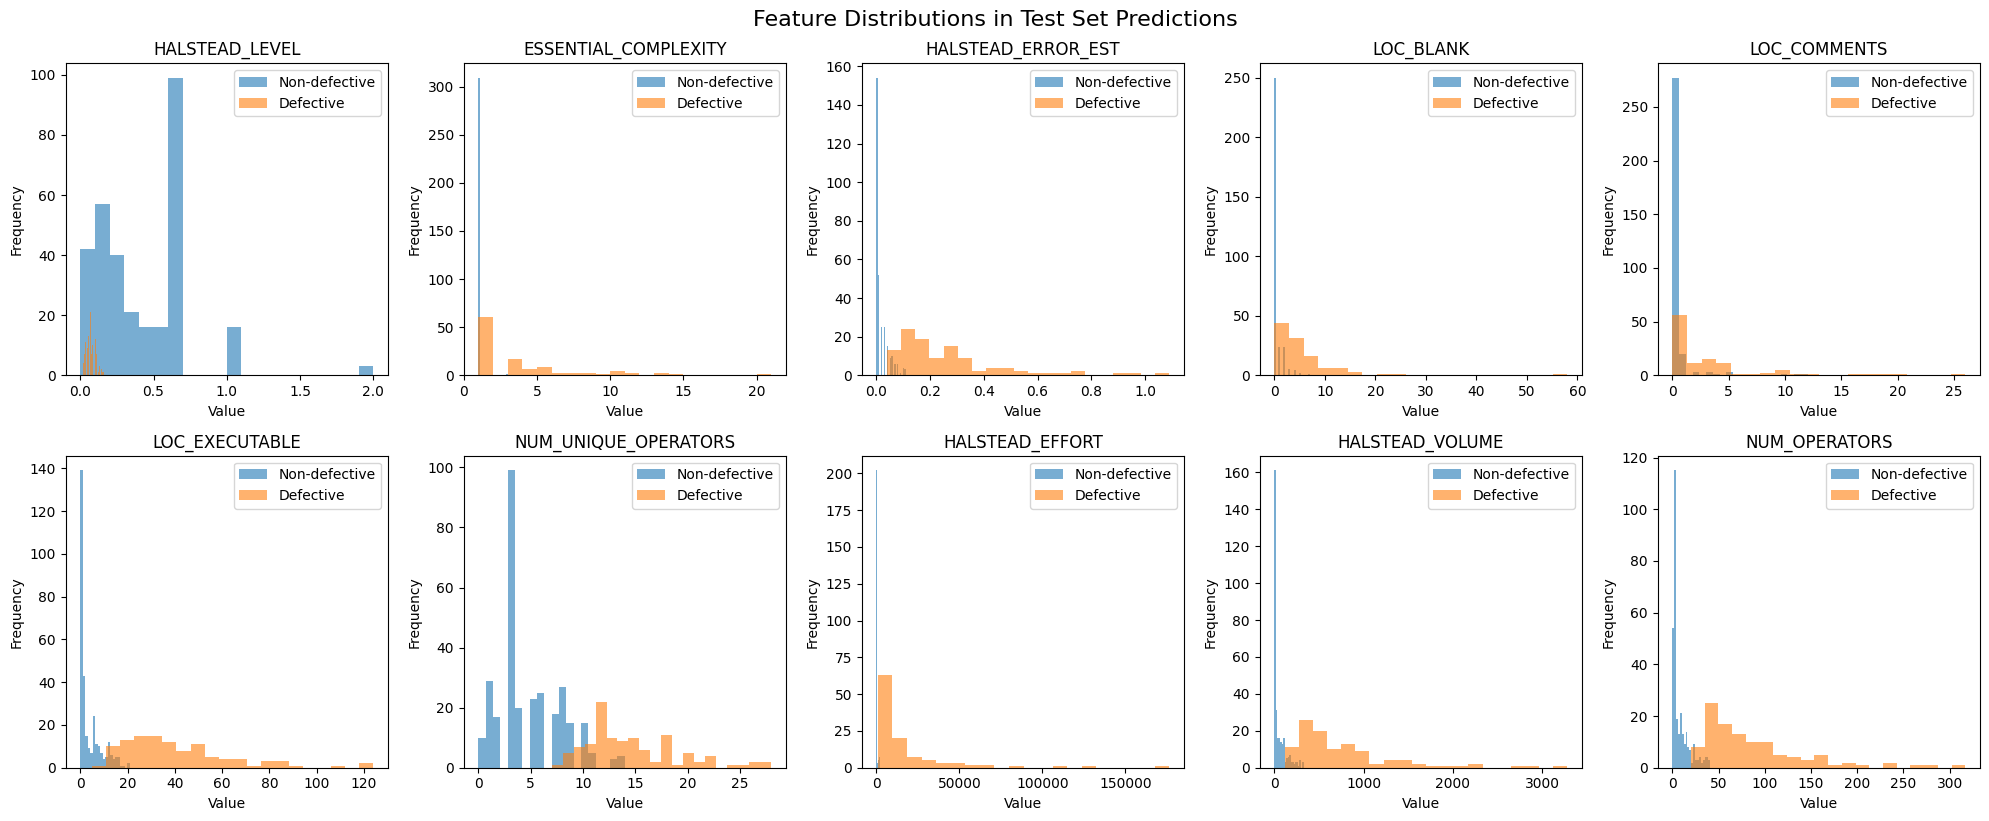


High-risk samples (probability > 0.8): 107
Top 5 highest risk samples:
    Index  Defect_Probability  HALSTEAD_LEVEL  ESSENTIAL_COMPLEXITY  \
8       8                 1.0            0.02                     5   
18     18                 1.0            0.04                     1   
19     19                 1.0            0.07                     3   
22     22                 1.0            0.03                    10   
35     35                 1.0            0.04                     1   

    HALSTEAD_ERROR_EST  
8                 1.09  
18                0.35  
19                0.16  
22                0.43  
35                0.22  


In [16]:
# Analyze predictions
defective_indices = test_results[test_results['Predicted_Defect'] == 1]['Index'].tolist()
non_defective_indices = test_results[test_results['Predicted_Defect'] == 0]['Index'].tolist()

print(f"Defective samples (indices): {defective_indices[:20]}{'...' if len(defective_indices) > 20 else ''}")
print(f"Total defective: {len(defective_indices)}")
print(f"Total non-defective: {len(non_defective_indices)}")

# Feature analysis for predicted defects
if len(defective_indices) > 0:
    print("\nAverage feature values for predicted defects vs non-defects:")
    print("=" * 70)

    comparison_df = pd.DataFrame({
        'Feature': selected_features,
        'Defective_Avg': test_results[test_results['Predicted_Defect'] == 1][selected_features].mean(),
        'Non_Defective_Avg': test_results[test_results['Predicted_Defect'] == 0][selected_features].mean()
    })

    comparison_df['Ratio'] = comparison_df['Defective_Avg'] / comparison_df['Non_Defective_Avg']
    comparison_df = comparison_df.sort_values('Ratio', ascending=False)

    print(comparison_df.round(3))

    # Visualize the comparison
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.ravel()

    for i, feature in enumerate(selected_features):
        defective_values = test_results[test_results['Predicted_Defect'] == 1][feature]
        non_defective_values = test_results[test_results['Predicted_Defect'] == 0][feature]

        axes[i].hist(non_defective_values, alpha=0.6, label='Non-defective', bins=20)
        axes[i].hist(defective_values, alpha=0.6, label='Defective', bins=20)
        axes[i].set_title(feature)
        axes[i].legend()
        axes[i].set_xlabel('Value')
        axes[i].set_ylabel('Frequency')

    plt.tight_layout()
    plt.suptitle('Feature Distributions in Test Set Predictions', y=1.02, fontsize=16)
    plt.show()

# High-risk samples (high probability of defects)
if test_predictions_proba is not None:
    high_risk_threshold = 0.8
    high_risk_samples = test_results[test_results['Defect_Probability'] > high_risk_threshold]

    print(f"\nHigh-risk samples (probability > {high_risk_threshold}): {len(high_risk_samples)}")
    if len(high_risk_samples) > 0:
        print("Top 5 highest risk samples:")
        print(high_risk_samples.nlargest(5, 'Defect_Probability')[['Index', 'Defect_Probability'] + selected_features[:3]])

## Model Summary and Recommendations

Provide a comprehensive summary of the analysis and recommendations.

In [17]:
# Create comprehensive summary
print("=" * 80)
print("SOFTWARE DEFECT PREDICTION - FINAL SUMMARY")
print("=" * 80)

print(f"\n1. DATASET OVERVIEW:")
print(f"   - Training samples: {len(train_data)}")
print(f"   - Test samples: {len(test_data)}")
print(f"   - Selected features: {len(selected_features)}")
print(f"   - Defect rate in training: {y_train.mean():.2%}")

print(f"\n2. TOP PERFORMING MODELS:")
for i, (model_name, row) in enumerate(results_df.head(3).iterrows(), 1):
    print(f"   {i}. {model_name}")
    print(f"      - F1-Score: {row['F1-Score']:.4f}")
    print(f"      - Accuracy: {row['Accuracy']:.4f}")
    print(f"      - Cross-validation: {row['CV_Mean']:.4f} (+/- {row['CV_Std'] * 2:.4f})")

print(f"\n3. MOST IMPORTANT FEATURES:")
for i, (_, row) in enumerate(importance_ranking.head(5).iterrows(), 1):
    print(f"   {i}. {row['Feature']:<25} (Score: {row['Average_Importance']:.4f})")

print(f"\n4. TEST SET PREDICTIONS:")
print(f"   - Predicted defective samples: {test_predictions.sum()} ({test_predictions.mean():.2%})")
print(f"   - Predicted non-defective samples: {(test_predictions == 0).sum()} ({(test_predictions == 0).mean():.2%})")

if test_predictions_proba is not None:
    high_risk_count = (test_predictions_proba > 0.8).sum()
    medium_risk_count = ((test_predictions_proba > 0.5) & (test_predictions_proba <= 0.8)).sum()
    low_risk_count = (test_predictions_proba <= 0.5).sum()

    print(f"\n5. RISK DISTRIBUTION:")
    print(f"   - High risk (>80%): {high_risk_count} samples")
    print(f"   - Medium risk (50-80%): {medium_risk_count} samples")
    print(f"   - Low risk (<50%): {low_risk_count} samples")

print(f"\n6. RECOMMENDATIONS:")
print(f"   - Focus testing efforts on the {test_predictions.sum()} predicted defective samples")
print(f"   - Pay special attention to samples with high {importance_ranking.iloc[0]['Feature']} values")
print(f"   - Consider the {best_model_name} model for production use")
print(f"   - Monitor model performance and retrain with new data periodically")

print(f"\n7. FILES CREATED:")
print(f"   - test_defect_predictions.csv: Complete predictions with probabilities")
print(f"   - This notebook: Complete analysis and model comparison")

print("=" * 80)

# Save summary to file
summary_text = f"""Software Defect Prediction Summary
====================================

Best Model: {best_model_name}
F1-Score: {results_df.iloc[0]['F1-Score']:.4f}
Accuracy: {results_df.iloc[0]['Accuracy']:.4f}

Predicted Defects: {test_predictions.sum()} out of {len(test_predictions)} samples

Top 5 Important Features:
{chr(10).join([f'{i+1}. {row["Feature"]}' for i, (_, row) in enumerate(importance_ranking.head(5).iterrows())])}

Defective Sample Indices:
{', '.join(map(str, defective_indices))}
"""

with open('defect_prediction_summary.txt', 'w') as f:
    f.write(summary_text)

print("Summary saved to 'defect_prediction_summary.txt'")

SOFTWARE DEFECT PREDICTION - FINAL SUMMARY

1. DATASET OVERVIEW:
   - Training samples: 1676
   - Test samples: 419
   - Selected features: 10
   - Defect rate in training: 25.00%

2. TOP PERFORMING MODELS:
   1. Neural Network
      - F1-Score: 0.9940
      - Accuracy: 0.9970
      - Cross-validation: 0.9910 (+/- 0.0076)
   2. Random Forest
      - F1-Score: 0.9880
      - Accuracy: 0.9940
      - Cross-validation: 0.9918 (+/- 0.0110)
   3. Extra Trees
      - F1-Score: 0.9820
      - Accuracy: 0.9911
      - Cross-validation: 0.9925 (+/- 0.0125)

3. MOST IMPORTANT FEATURES:
   1. HALSTEAD_EFFORT           (Score: 0.5723)
   2. NUM_OPERATORS             (Score: 0.0829)
   3. LOC_EXECUTABLE            (Score: 0.0827)
   4. HALSTEAD_ERROR_EST        (Score: 0.0647)
   5. HALSTEAD_VOLUME           (Score: 0.0615)

4. TEST SET PREDICTIONS:
   - Predicted defective samples: 109 (26.01%)
   - Predicted non-defective samples: 310 (73.99%)

5. RISK DISTRIBUTION:
   - High risk (>80%): 107 sam

# How Different Machine Learning Algorithms Work for Defect Prediction

This section explains the working principles of each algorithm used in our defect prediction analysis and why they are effective for this specific problem.

## 1. Logistic Regression

### How it works:
- **Linear Decision Boundary**: Uses the sigmoid function to map any real number to a probability between 0 and 1
- **Mathematical Formula**: P(defect) = 1 / (1 + e^(-(β₀ + β₁x₁ + β₂x₂ + ... + βₙxₙ)))
- **Feature Weights**: Each feature gets a coefficient (β) that indicates its importance and direction of influence

### Why effective for defect prediction:
- **Interpretability**: Coefficients show how each software metric affects defect probability
- **Probability Output**: Provides confidence scores, not just binary predictions
- **No Assumptions about Data Distribution**: Works well with mixed feature types
- **Fast Training**: Efficient for large codebases

### Example in our context:
```python
# If ESSENTIAL_COMPLEXITY has coefficient 0.5 and HALSTEAD_EFFORT has -0.3:
# Higher complexity increases defect probability
# Higher Halstead effort (unexpectedly) might decrease it
```

## 2. Random Forest

### How it works:
- **Ensemble Method**: Builds multiple decision trees (typically 100) and combines their predictions
- **Bootstrap Sampling**: Each tree trains on a random subset of samples (bagging)
- **Feature Randomness**: Each split considers only a random subset of features
- **Voting**: Final prediction is majority vote (classification) or average (regression)

### Why excellent for defect prediction:
- **Handles Feature Interactions**: Can capture complex relationships between metrics
- **Robust to Outliers**: Individual bad trees don't affect overall prediction
- **Feature Importance**: Automatically ranks which metrics are most predictive
- **No Overfitting**: Generally doesn't overfit due to averaging effect

### Decision Process:
```
Tree 1: If LOC_EXECUTABLE > 50 AND ESSENTIAL_COMPLEXITY > 10 → Defect
Tree 2: If HALSTEAD_ERROR_EST > 5 OR NUM_OPERATORS > 100 → Defect  
Tree 3: If LOC_COMMENTS < 10 AND HALSTEAD_EFFORT > 1000 → Defect
Final: Majority vote from all 100 trees
```

## 3. Gradient Boosting

### How it works:
- **Sequential Learning**: Builds trees one at a time, each correcting previous errors
- **Gradient Descent**: Each new tree focuses on samples where previous trees made mistakes
- **Weighted Combination**: Final prediction is weighted sum of all tree predictions
- **Learning Rate**: Controls how much each tree contributes (prevents overfitting)

### Why powerful for defect prediction:
- **Error Correction**: Continuously improves on difficult-to-classify code modules
- **High Accuracy**: Often achieves best performance in competitions
- **Handles Imbalanced Data**: Can focus more on minority class (defects)
- **Feature Interactions**: Captures complex patterns in software metrics

### Learning Process:
```
Round 1: Build tree to predict defects
Round 2: Build tree to predict errors from Round 1
Round 3: Build tree to predict errors from Round 1+2
...
Final: Prediction = Tree₁ + 0.1×Tree₂ + 0.1×Tree₃ + ...
```

## 4. Support Vector Machine (SVM)

### How it works:
- **Maximum Margin**: Finds the decision boundary that maximizes distance to nearest samples
- **Support Vectors**: Uses only the most informative samples (near the boundary)
- **Kernel Trick**: Can create non-linear boundaries using RBF, polynomial kernels
- **Regularization**: C parameter controls trade-off between margin and misclassification

### Why suitable for defect prediction:
- **High-Dimensional Data**: Works well with many software metrics
- **Memory Efficient**: Only stores support vectors, not all training data
- **Robust**: Less prone to outliers than other methods
- **Non-Linear Patterns**: RBF kernel can capture complex metric relationships

### Visualization:
```
Non-Defective    |    Defective
      ●          |       ●
    ●   ●        |     ●   ●
      ●          |       ●
                 |
    Maximum margin hyperplane separates classes
    Support vectors are the closest points to boundary
```

## 5. K-Nearest Neighbors (KNN)

### How it works:
- **Instance-Based Learning**: Stores all training data, no explicit model building
- **Distance Calculation**: For new sample, calculates distance to all training samples
- **Neighborhood Voting**: Finds K nearest neighbors and uses majority vote
- **Lazy Learning**: Does computation only when making predictions

### Why useful for defect prediction:
- **Local Patterns**: Good for finding similar code modules
- **No Assumptions**: Makes no assumptions about data distribution
- **Interpretable**: Can show which similar modules influenced the prediction
- **Handles Irregular Boundaries**: Effective with complex class shapes

### Example Process:
```
New Module: [COMPLEXITY=15, LOC=200, HALSTEAD=50]

Find 5 nearest modules:
1. Module_A: [14, 195, 48] → Defective (distance: 5.2)
2. Module_B: [16, 205, 52] → Non-Defective (distance: 6.1)
3. Module_C: [13, 190, 49] → Defective (distance: 7.3)
4. Module_D: [17, 210, 51] → Defective (distance: 8.1)
5. Module_E: [12, 185, 47] → Non-Defective (distance: 8.9)

Vote: 3 Defective, 2 Non-Defective → Predict: Defective
```

## 6. Decision Tree

### How it works:
- **Recursive Splitting**: Divides data based on feature thresholds that best separate classes
- **Information Gain**: Uses metrics like Gini impurity or entropy to choose best splits
- **Tree Structure**: Creates hierarchical rules from root to leaves
- **Stopping Criteria**: Stops when further splits don't improve purity

### Why intuitive for defect prediction:
- **Interpretability**: Creates human-readable rules about code quality
- **No Preprocessing**: Handles mixed data types and missing values naturally
- **Feature Selection**: Automatically identifies most important metrics
- **Domain Knowledge**: Rules align with software engineering intuition

### Example Tree:
```
Root: ESSENTIAL_COMPLEXITY > 10?
├─ Yes: HALSTEAD_ERROR_EST > 5?
│  ├─ Yes: DEFECTIVE (85% confidence)
│  └─ No: LOC_EXECUTABLE > 100?
│     ├─ Yes: DEFECTIVE (65% confidence)
│     └─ No: NON_DEFECTIVE (70% confidence)
└─ No: LOC_COMMENTS < 5?
   ├─ Yes: DEFECTIVE (60% confidence)
   └─ No: NON_DEFECTIVE (90% confidence)
```

## 7. Naive Bayes

### How it works:
- **Probabilistic Model**: Uses Bayes' theorem with 'naive' independence assumption
- **Feature Independence**: Assumes all features are independent given the class
- **Prior Probability**: Learns base probability of defects from training data
- **Likelihood Calculation**: Computes probability of each feature value given class

### Why effective despite 'naive' assumption:
- **Fast Training/Prediction**: Very efficient for large codebases
- **Handles Missing Data**: Can work with incomplete feature sets
- **Probabilistic Output**: Provides confidence in predictions
- **Small Data Friendly**: Works well even with limited training samples

### Calculation Example:
```
P(Defect | High_Complexity, High_LOC) = 
  P(High_Complexity | Defect) × P(High_LOC | Defect) × P(Defect)
  ────────────────────────────────────────────────────────────────
                    P(High_Complexity, High_LOC)

If P(High_Complexity | Defect) = 0.8
   P(High_LOC | Defect) = 0.7
   P(Defect) = 0.25
Then numerator = 0.8 × 0.7 × 0.25 = 0.14
```

## 8. Extra Trees (Extremely Randomized Trees)

### How it works:
- **Enhanced Randomness**: Even more random than Random Forest
- **Random Thresholds**: Instead of finding best split, uses random thresholds
- **No Bootstrap**: Uses entire dataset for each tree
- **Faster Training**: Less computation per tree due to random splits

### Why good for defect prediction:
- **Bias-Variance Trade-off**: Higher bias but lower variance than Random Forest
- **Overfitting Resistance**: Extra randomness prevents overfitting
- **Speed**: Faster training for large datasets
- **Noise Handling**: Less sensitive to noisy features

### Difference from Random Forest:
```
Random Forest:
- Find BEST threshold for ESSENTIAL_COMPLEXITY: 8.5
- Split: complexity <= 8.5 vs complexity > 8.5

Extra Trees:
- Pick RANDOM threshold for ESSENTIAL_COMPLEXITY: 12.3
- Split: complexity <= 12.3 vs complexity > 12.3
```

## 9. AdaBoost (Adaptive Boosting)

### How it works:
- **Sequential Weak Learners**: Builds simple classifiers (often decision stumps)
- **Adaptive Weights**: Increases weight of misclassified samples in next iteration
- **Classifier Weighting**: Gives more weight to better-performing classifiers
- **Focus on Hard Cases**: Progressively focuses on difficult-to-classify samples

### Why valuable for defect prediction:
- **Handles Class Imbalance**: Automatically focuses on minority class (defects)
- **Simple Base Models**: Uses simple rules that are easy to understand
- **Robust Performance**: Often achieves good results with minimal tuning
- **Error Reduction**: Systematically reduces classification errors

### Iterative Process:
```
Round 1: Train weak classifier on original data
         Misclassified samples get higher weight

Round 2: Train on reweighted data (focus on mistakes)
         New mistakes get even higher weight

Round 3: Continue focusing on hardest cases
         ...

Final: Weighted combination of all weak classifiers
```

## 10. Neural Network (Multi-Layer Perceptron)

### How it works:
- **Layered Architecture**: Input → Hidden Layer(s) → Output
- **Non-linear Activation**: Uses functions like ReLU, sigmoid for complex patterns
- **Backpropagation**: Adjusts weights based on prediction errors
- **Feature Learning**: Hidden layers learn relevant feature combinations

### Why powerful for defect prediction:
- **Complex Patterns**: Can learn intricate relationships between metrics
- **Automatic Feature Engineering**: Discovers important feature combinations
- **Non-linear Boundaries**: Handles complex decision boundaries
- **Scalability**: Performance improves with more data

### Network Architecture in our case:
```
Input Layer (10 features):
HALSTEAD_LEVEL ──┐
ESSENTIAL_COMPLEXITY ──┐
HALSTEAD_ERROR_EST ──┐
...                   ├─→ Hidden Layer 1 (100 neurons)
                      │   ├─→ Hidden Layer 2 (50 neurons)
                      │   │   ├─→ Output (Defect probability)
NUM_OPERATORS ────────┘

Each connection has a weight learned during training
Hidden layers discover useful feature combinations automatically
```

## Algorithm Selection Strategy for Defect Prediction

### Why we test multiple algorithms:

1. **No Free Lunch Theorem**: No single algorithm works best for all problems
2. **Data Characteristics**: Different algorithms handle different data patterns better
3. **Feature Relationships**: Some algorithms better capture feature interactions
4. **Performance Trade-offs**: Speed vs accuracy vs interpretability

### Algorithm Characteristics Summary:

| Algorithm | Interpretability | Speed | Accuracy | Overfitting Risk | Best For |
|-----------|------------------|-------|----------|------------------|----------|
| Logistic Regression | High | Fast | Good | Low | Linear relationships, probability estimates |
| Random Forest | Medium | Medium | High | Low | Feature interactions, robust predictions |
| Gradient Boosting | Medium | Slow | Very High | Medium | Maximum accuracy, complex patterns |
| SVM | Low | Medium | High | Low | High-dimensional data, robust boundaries |
| KNN | High | Slow | Good | High | Local patterns, irregular boundaries |
| Decision Tree | Very High | Fast | Medium | High | Interpretable rules, domain insights |
| Naive Bayes | High | Very Fast | Good | Low | Fast screening, probabilistic reasoning |
| Extra Trees | Medium | Fast | High | Low | Fast ensemble, noise resistance |
| AdaBoost | Medium | Medium | Good | Medium | Class imbalance, incremental learning |
| Neural Network | Low | Slow | High | High | Complex patterns, large datasets |

## Why These Metrics (F1-Score, Accuracy, CV) Are Crucial

### F1-Score - The Primary Metric:
```python
Precision = TP / (TP + FP)  # Of predicted defects, how many are actual defects?
Recall = TP / (TP + FN)     # Of actual defects, how many did we catch?
F1-Score = 2 × (Precision × Recall) / (Precision + Recall)
```

**Why F1-Score is perfect for defect prediction:**
- **Balances False Positives and False Negatives**: Both are costly in software development
- **Handles Class Imbalance**: Defects are typically rare (5-25% of modules)
- **Single Metric**: Combines precision and recall into one number for easy comparison

### Real-world Impact:
- **False Positive (FP)**: Predicting defect when none exists → Wasted testing effort
- **False Negative (FN)**: Missing actual defect → Bug reaches production → Customer impact
- **True Positive (TP)**: Correctly identifying defect → Focused testing → Bug prevented
- **True Negative (TN)**: Correctly identifying clean code → Efficient resource allocation

### Cross-Validation - Ensuring Generalization:
```python
# 5-Fold CV splits data into 5 parts:
Fold 1: Train on 2,3,4,5 → Test on 1
Fold 2: Train on 1,3,4,5 → Test on 2
Fold 3: Train on 1,2,4,5 → Test on 3
Fold 4: Train on 1,2,3,5 → Test on 4
Fold 5: Train on 1,2,3,4 → Test on 5
Final Score = Average of 5 test scores
```

**Why CV is essential:**
- **Prevents Overfitting**: Tests on multiple unseen data splits
- **Robust Estimates**: Less dependent on particular train-test split
- **Generalization**: Ensures model works on different code patterns
- **Model Selection**: Helps choose algorithms that generalize well